<a href="https://colab.research.google.com/github/dpiponi/colabs/blob/main/Copy_of_Stochastic_Calculus_Examples_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

For Ito integral we expect that in the first interval we use $f$ from the beginning of the interval, so we use `exclusive=True`. (For ordinary calculus this isn't an issue but for stochastic calculus it is.)

In [ ]:
def integrate(fdx):
  return tf.cumsum(fdx, exclusive=True)

In [ ]:
n = 10000000
dt = tf.constant(1. / n, tf.float64)

$B_t$ is Brownian motion

In [ ]:
db = tfd.Normal(loc=tf.constant(0., tf.float64), scale=tf.sqrt(dt)).sample(n)
b = integrate(db)
ones = tf.ones(n, dtype=tf.float64)
t = integrate(ones * dt)

Examples from reference [1]:

$\int_0^tsdB_s=tB_t-\int_0^tB_sds$

In [ ]:
(
    integrate(t * db)[-1],
    (t * b - integrate(b * dt))[-1]
)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.03922161767586746>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.039221574881689425>)

$\int_0^tB_s^2dB_s=\frac{1}{3}B_t^3-\int_0^tB_sds$

In [ ]:
(
    integrate(b * b * db)[-1],
    b[-1] ** 3 / 3. - integrate(b * dt)[-1]
)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.44248526053394727>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.44246067095274877>)

Iterated Ito integral:

$n!\int\cdots(\mkern-30mu\int\limits_{
0\le u_1\le\cdots\le u_n\le t
}\mkern-22mu(\int dB_{u_1})dB_{u_2})\cdots dB_{u_n}=t^\frac{n}{2}h_n(\frac{B_t}{\sqrt{t}})$

$h_n$ is the $n$th (probabilist's) Hermite polynomial.

In [ ]:
(
    6 * integrate(integrate(integrate(db) * db) * db)[-1],
    b[-1]**3 - 3. * b[-1]
)

(<tf.Tensor: shape=(), dtype=float64, numpy=1.2096682072509348>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.209717417440085>)

We're going to solve

$dx(t) = f(x(t))dt + g(x(t))dB(t)$

using a simple forward Euler method and with $f(x) = x/4$ and $g(x)=x$.

Solving SDEs is serial in nature and we need an explicit loop - sped up with `@tf.function`.

In [ ]:
n = 1000000
dt = tf.constant(1. / n, tf.float64)
db = tfd.Normal(loc=0, scale=tf.sqrt(dt)).sample(n)

def f(x):
  return tf.constant(0.25, tf.float64) * x

def g(x):
  return tf.constant(1., tf.float64) * x

def body(i, x, u):
  dx = f(x) * dt + g(x) * db[i]
  return (i + 1, x + dx, u.write(i, dx))

x0 = 1.0

@tf.function
def test():
  u = tf.TensorArray(tf.float64, size=n)
  x = tf.constant(x0, tf.float64)
  i = tf.constant(0)
  c = lambda i, x, u: tf.less(i, n)
  r = tf.while_loop(c, body, [i, x, u])
  return r[2].stack()

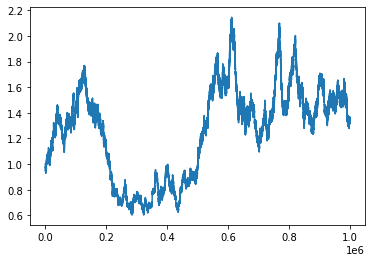

In [ ]:
dx = test()
x = x0 + integrate(dx)
plt.plot(x)

Let's test Ito's Formula

$dh(x(t)) = h'(x)dx + \frac{1}{2}h''(x)dx^2 = h'(x)dx + h''(x)g(x)^2dB^2$

In [ ]:
def h(x):
  return tf.exp(-x)
def h1(x):
  return -tf.exp(-x)
def h2(x):
  return tf.exp(-x)

In [ ]:
h(x[-1]) - h(x[0])

<tf.Tensor: shape=(), dtype=float64, numpy=-0.09934913051828931>

In [ ]:
integrate(h1(x) * dx)[-1] + 0.5 * integrate(h2(x) * dx**2)[-1]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.0993491052206735>

In [ ]:
integrate(h1(x) * dx)[-1] + 0.5 * integrate(h2(x) * g(x)**2 * db**2)[-1]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.09934913862956321>

Some results from [2]:

$dx^2=g(x)^2dt$

(Equality in the sense of being almost surely true after being integrated.)

In [ ]:
integrate(dx * dx)[-1], integrate(g(x)**2 * dt)[-1]

(<tf.Tensor: shape=(), dtype=float64, numpy=1.7145921438205147>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.70861697716962>)

$\frac{(dx)^4}{dt}=3g(x)^4dt$

In [ ]:
integrate(dx**4 / dt)[-1], 3. * integrate(g(x)**4 * dt)[-1]

(<tf.Tensor: shape=(), dtype=float64, numpy=11.153778844453852>,
 <tf.Tensor: shape=(), dtype=float64, numpy=11.081693337575587>)

$\frac{(dx)^6}{dt^2}=15g(x)^6dt$

(I'd expect the high powers to mean this won't be as accurate unless we make dt smaller.)

In [ ]:
integrate(dx**6 / dt**2)[-1], 15. * integrate(g(x)**6 * dt)[-1]

(<tf.Tensor: shape=(), dtype=float64, numpy=138.85468811523484>,
 <tf.Tensor: shape=(), dtype=float64, numpy=137.33432179590136>)

This doesn't work well. So I'm misunderstanding something or I should check the derivation to see how well it holds for finite size dt. That's useful information! (I probably ought to read the paper properly.)

$\frac{(dx)^3}{dt}=3g(x)^2dx$

In [ ]:
integrate(dx ** 3 / dt)[-1], 3. * integrate(g(x)**2 * dx)[-1]

(<tf.Tensor: shape=(), dtype=float64, numpy=-1.3995071227653748>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-6.128088735150699>)

# References

1. Stochastic Differential Equations: An Introduction with Applications, Bernt Oksendal
2. [Rules of calculus in the path integral representation of white noise Langevin equations: the Onsager–Machlup approach](https://arxiv.org/abs/1704.03501)